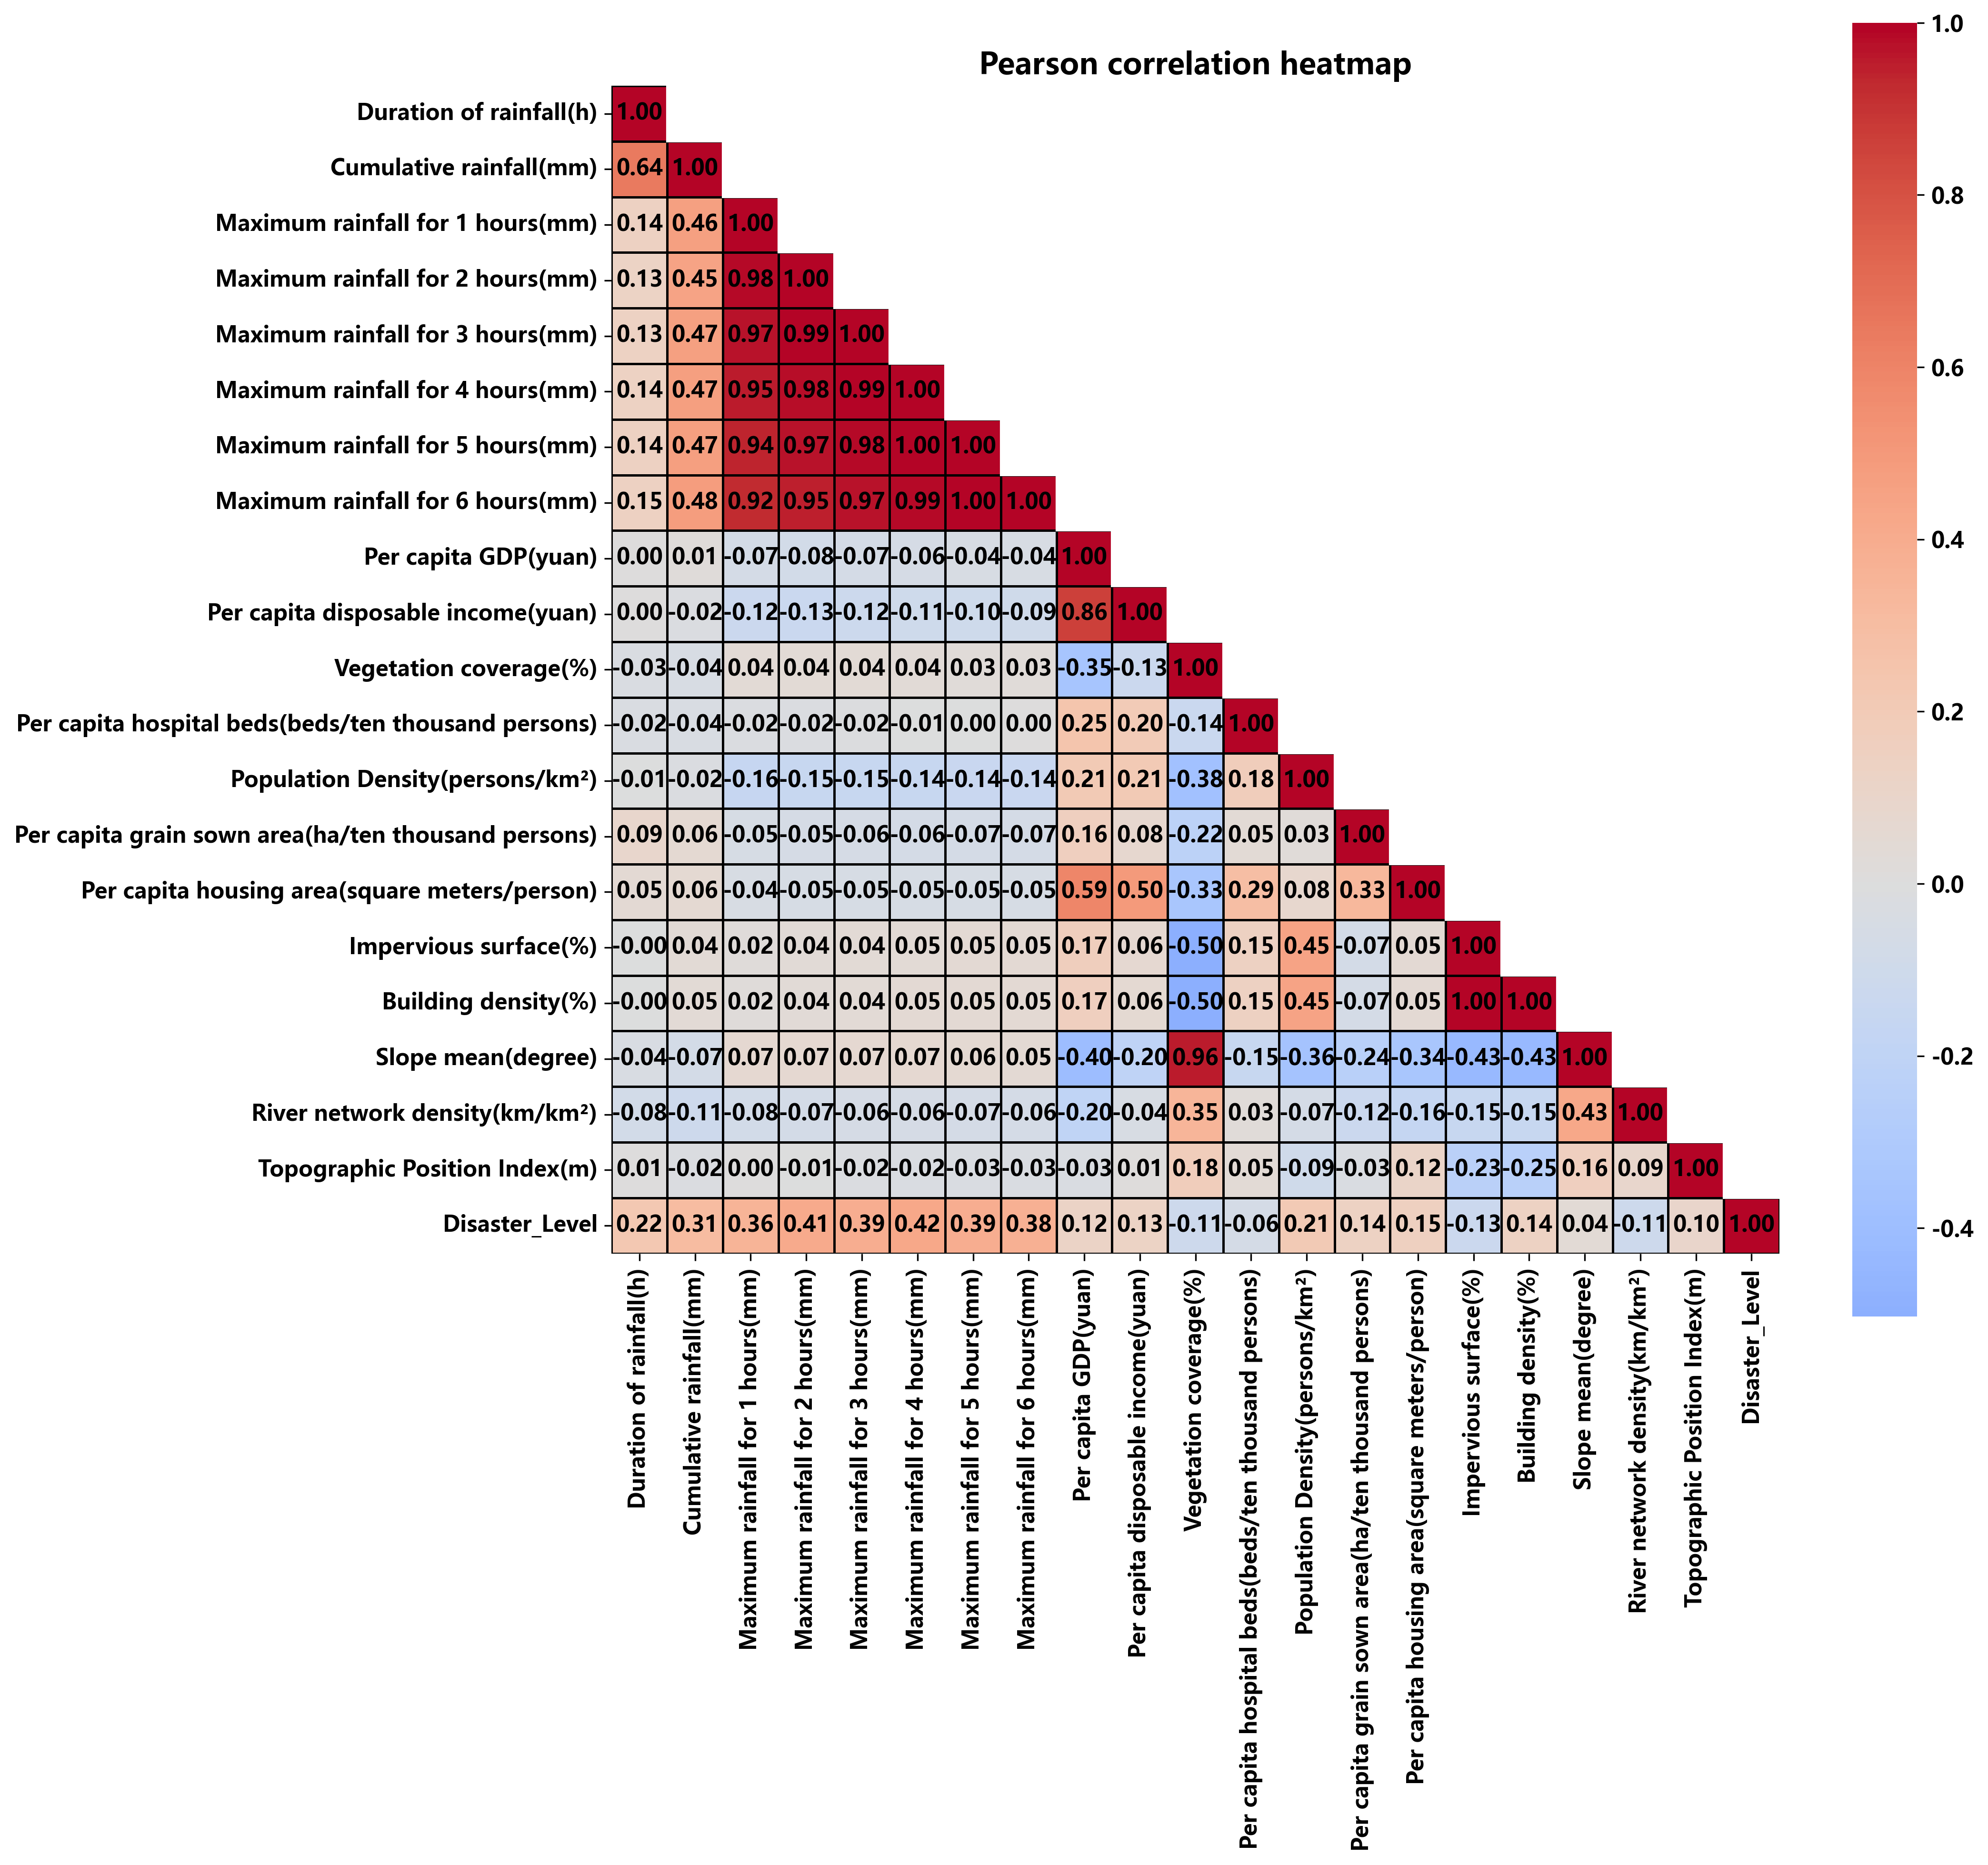

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib
import numpy as np
from matplotlib.patches import Rectangle

# Font settings
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['xtick.labelsize'] = 11
matplotlib.rcParams['ytick.labelsize'] = 11
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'

# Output folder
output_dir = 'output_corr'
os.makedirs(output_dir, exist_ok=True)

# Feature mapping
feature_mapping = {
    '持续时间(小时)': 'Duration of rainfall(h)',
    '累计降雨量': 'Cumulative rainfall(mm)',
    '逐1小时最大雨量': 'Maximum rainfall for 1 hours(mm)',
    '逐2小时最大雨量': 'Maximum rainfall for 2 hours(mm)',
    '逐3小时最大雨量': 'Maximum rainfall for 3 hours(mm)',
    '逐4小时最大雨量': 'Maximum rainfall for 4 hours(mm)',
    '逐5小时最大雨量': 'Maximum rainfall for 5 hours(mm)',
    '逐6小时最大雨量': 'Maximum rainfall for 6 hours(mm)',
    '人均GDP': 'Per capita GDP(yuan)',
    '人均可支配收入': 'Per capita disposable income(yuan)',
    'tree_cover_mean': 'Vegetation coverage(%)',
    '人均床位数（个/万人）': 'Per capita hospital beds(beds/ten thousand persons)',
    '人口密度（人/平方公里）': 'Population Density(persons/km²)',
    '人均播种面积（千公顷/万人）': 'Per capita grain sown area(ha/ten thousand persons)',
    '人均房屋建筑施工面积（万平方米/人）': 'Per capita housing area(square meters/person)',
    'Impervious_Surface_mean': 'Impervious surface(%)',
    'built_density_mean': 'Building density(%)',
    'slope_mean': 'Slope mean(degree)',
    'river_density_mean': 'River network density(km/km²)',
    'TPI_mean': 'Topographic Position Index(m)'
}

# Load data
data = pd.read_csv('训练4.0_filled.csv', encoding='gbk')
data = data.rename(columns=feature_mapping)

features = list(feature_mapping.values())
X = data[features]
y = data['CPI订正的直接经济损失（万元）']
X = X.fillna(0)

# Target variable classification
bins = [0, 8000, 15000, 35000, float('inf')]
labels = ['Minor Disaster', 'Medium Disaster', 'Major Disaster', 'Catastrophic Disaster']
y = pd.cut(y, bins=bins, labels=labels)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

data_combined = X.copy()
data_combined['Disaster_Level'] = y_encoded

# Plot function (mask upper triangle borders)
def plot_corr_heatmap(corr_matrix, title, filename):
    n = corr_matrix.shape[0]
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    fig_size = min(max(n * 0.7, 7), 15)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size), dpi=300)

    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt='.2f',
        linewidths=1.2,
        linecolor='black',
        annot_kws={"size": 11, "weight": "bold", "color": "black"},
        cbar_kws={"shrink": 0.8},
        square=True,
        ax=ax
    )

    # Manually cover the upper triangle borders
    for i in range(n):
        for j in range(n):
            if j > i:
                ax.add_patch(Rectangle((j, i), 1, 1, color='white', zorder=3))

    ax.set_title(title, fontsize=15, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, weight='bold', fontname='Microsoft YaHei', rotation=90, ha='center')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=11, weight='bold', fontname='Microsoft YaHei', rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), format='svg', bbox_inches='tight')
    plt.show()  
    plt.close()


# Generate heatmap
plot_corr_heatmap(data_combined.corr(method='pearson'), 'Pearson correlation heatmap', 'pearson1_corr_heatmap.svg')


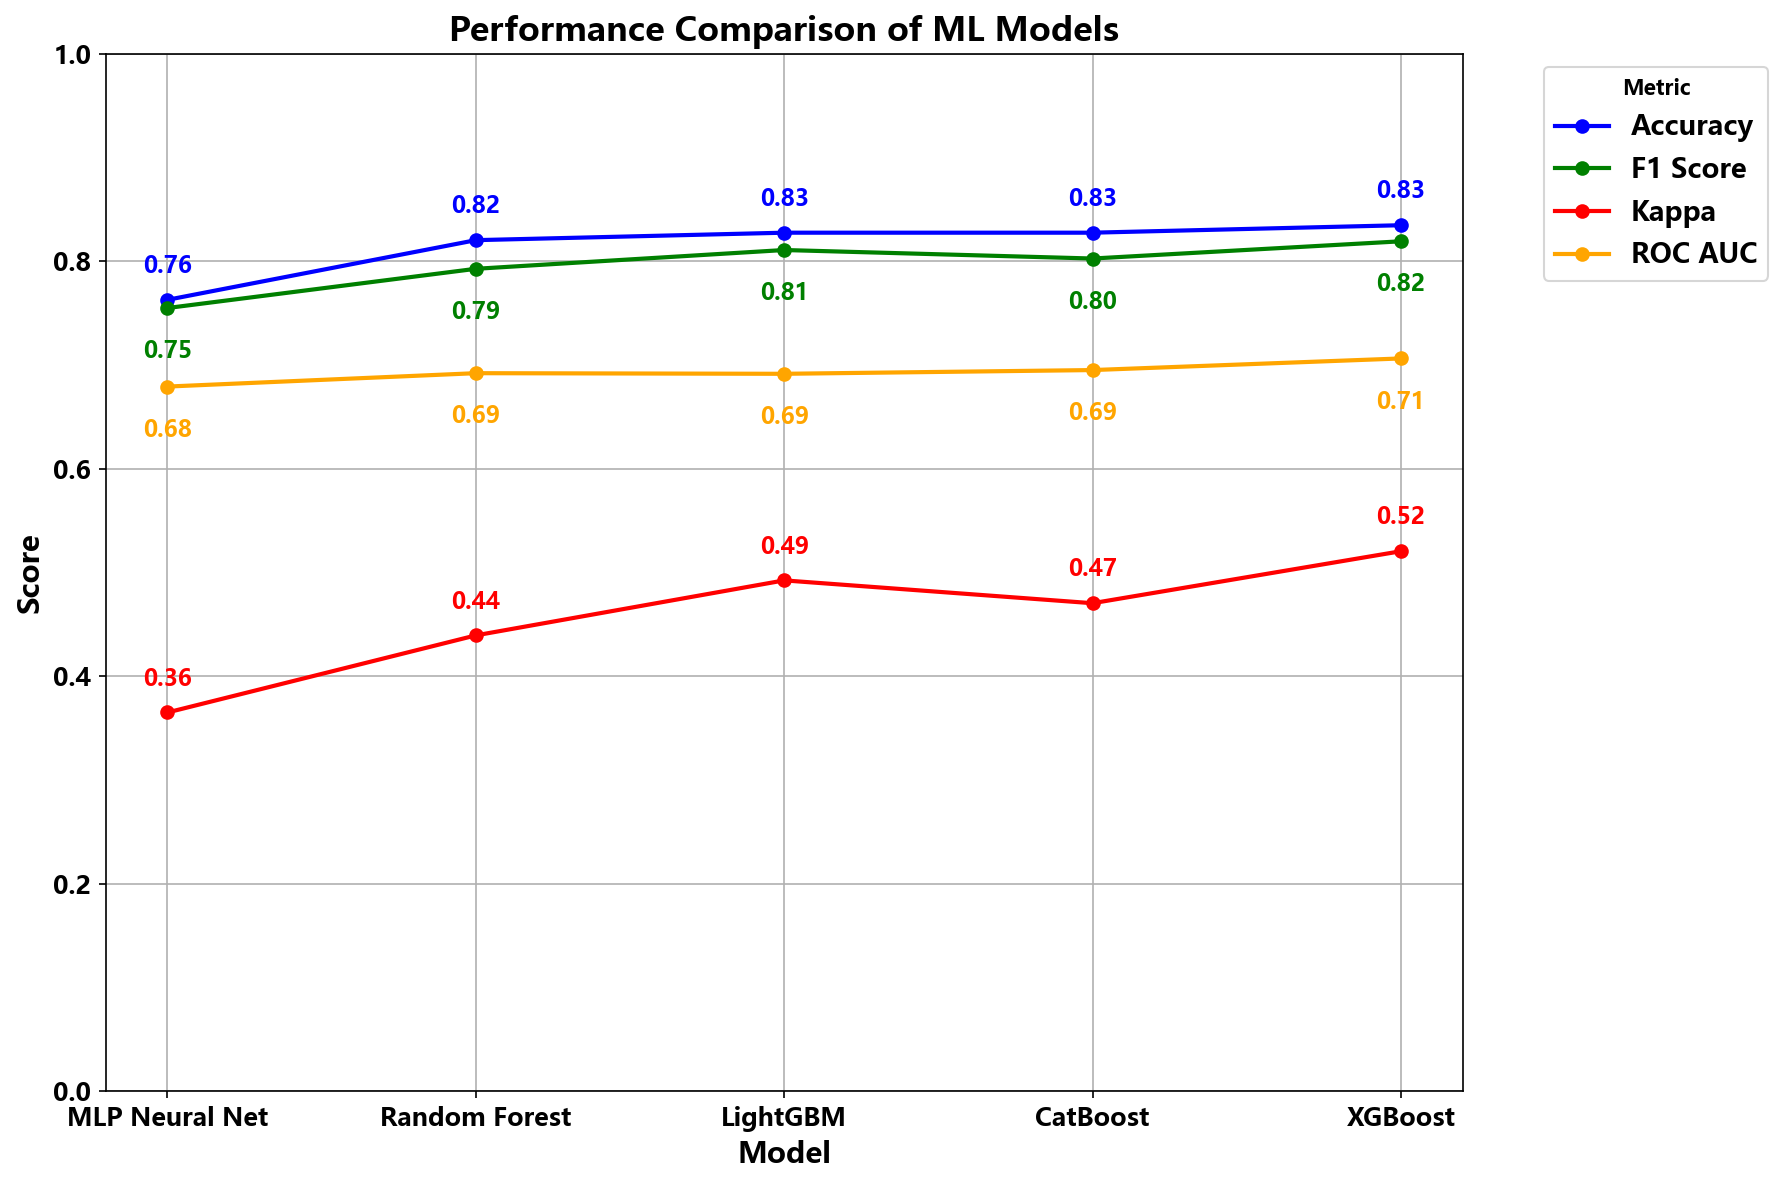

            Model  Accuracy  F1 Score   Kappa  ROC AUC
0  MLP Neural Net    0.7626    0.7547  0.3649   0.6790
1   Random Forest    0.8201    0.7925  0.4392   0.6919
2        LightGBM    0.8273    0.8106  0.4922   0.6913
3        CatBoost    0.8273    0.8024  0.4702   0.6949
4         XGBoost    0.8345    0.8190  0.5203   0.7061


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import matplotlib
import warnings

# —— Global style settings —— #
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'

warnings.filterwarnings("ignore")

# —— Output folder —— #
output_line_dir = 'output_line'
os.makedirs(output_line_dir, exist_ok=True)

# —— Data preprocessing —— #
data = pd.read_csv('训练4.0_filled.csv', encoding='gbk')

features = [
    '持续时间(小时)', '累计降雨量', '逐1小时最大雨量', '逐2小时最大雨量',
    '逐3小时最大雨量', '逐4小时最大雨量', '逐5小时最大雨量', '逐6小时最大雨量',
    '人均GDP', '人均可支配收入', 'tree_cover_mean',
    '人均床位数（个/万人）', '人口密度（人/平方公里）',
    '人均播种面积（千公顷/万人）', '人均房屋建筑施工面积（万平方米/人）',
    'Impervious_Surface_mean','built_density_mean',
    'slope_mean','river_density_mean','TPI_mean'
]

X = data[features].fillna(0)
y_raw = data['CPI订正的直接经济损失（万元）']

# Discretize into four categories
bins = [0, 8000, 15000, 35000, float('inf')]
labels = ['Minor', 'Medium', 'Major', 'Catastrophic']
y_cat = pd.cut(y_raw, bins=bins, labels=labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_cat)

# —— Model definitions —— #
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        bootstrap=True,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        objective='multiclass',
        num_class=4,
        learning_rate=0.1,
        n_estimators=300,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1
    ),
    'XGBoost': XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        learning_rate=0.1,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42
    ),
    'CatBoost': CatBoostClassifier(
        loss_function='MultiClass',
        iterations=500,
        depth=6,
        learning_rate=0.1,
        l2_leaf_reg=3.0,
        random_state=42,
        verbose=0
    ),
    'MLP Neural Net': MLPClassifier(
        hidden_layer_sizes=(100,), 
        max_iter=1000, 
        alpha=0.001,
        random_state=42
    )
}

# =========================================================
# ========== Monte Carlo Cross-Validation ============
# Perform 5 independent 70/30 random splits, train & evaluate,
# then average metrics across runs
# =========================================================
seeds = [101, 201, 301, 401, 501]  # 5 random splits

# Store results for each run
records = []  

for s in seeds:
    # Split data 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.3, random_state=s
    )

    # Scale features 
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        # Clone a new model instance for each run to avoid state carryover
        if name == 'Random Forest':
            model_i = RandomForestClassifier(
                n_estimators=200, max_depth=None, bootstrap=True,
                class_weight='balanced', random_state=42, n_jobs=-1
            )
        elif name == 'LightGBM':
            model_i = LGBMClassifier(
                objective='multiclass', num_class=4, learning_rate=0.1,
                n_estimators=300, num_leaves=31, subsample=0.8,
                colsample_bytree=0.8, reg_lambda=1.0,
                random_state=42, verbose=-1
            )
        elif name == 'XGBoost':
            model_i = XGBClassifier(
                objective='multi:softprob', num_class=4,
                learning_rate=0.1, n_estimators=300, max_depth=6,
                subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                eval_metric='mlogloss', tree_method='hist',
                random_state=42
            )
        elif name == 'CatBoost':
            model_i = CatBoostClassifier(
                loss_function='MultiClass', iterations=500,
                depth=6, learning_rate=0.1, l2_leaf_reg=3.0,
                random_state=42, verbose=0
            )
        else:  # 'MLP Neural Net'
            model_i = MLPClassifier(
                hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001,
                random_state=42
            )

        # Train & predict
        model_i.fit(X_train_scaled, y_train)
        y_pred = model_i.predict(X_test_scaled)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_test, y_pred)

        # Original ROC calculation: correctness label + max class probability as confidence
        y_test_arr = np.asarray(y_test).flatten()
        y_pred_arr = np.asarray(y_pred).flatten()
        correct = (y_pred_arr == y_test_arr).astype(int)

        proba = model_i.predict_proba(X_test_scaled)
        prob_max = np.max(proba, axis=1)

        assert correct.shape[0] == prob_max.shape[0], \
            f"Sample size mismatch: {correct.shape[0]} vs {prob_max.shape[0]}"

        fpr, tpr, _ = roc_curve(correct, prob_max, pos_label=1)
        roc_auc = auc(fpr, tpr)

        records.append({
            'Seed': s,
            'Model': name,
            'Accuracy': acc,
            'F1 Score': f1,
            'Kappa': kappa,
            'ROC AUC': roc_auc
        })

# Aggregate metrics by mean
per_run_df = pd.DataFrame(records)

# Compute average for each model across 5 splits
avg_df = (
    per_run_df
    .groupby('Model')[['Accuracy', 'F1 Score', 'Kappa', 'ROC AUC']]
    .mean()
    .reset_index()
)


# —— Sort by Accuracy —— #
results_df = avg_df.sort_values(by='Accuracy').reset_index(drop=True)

# —— Visualization  —— #
plt.figure(dpi=150, figsize=(12, 8))
metrics = ['Accuracy', 'F1 Score', 'Kappa', 'ROC AUC']
colors = ['b', 'g', 'r', 'orange']

for metric, color in zip(metrics, colors):
    plt.plot(
        results_df['Model'], results_df[metric],
        marker='o', label=metric, color=color, linewidth=2
    )

for i in range(len(results_df)):
    for metric, offset, va, color in zip(
        metrics,
        [0.02, -0.03, 0.02, -0.03],
        ['bottom', 'top', 'bottom', 'top'],
        colors
    ):
        val = results_df.loc[i, metric]
        plt.text(
            i, val + offset, f"{val:.2f}",
            ha='center', va=va, fontsize=11, color=color
        )

plt.legend(
    title="Metric", loc="upper left",
    bbox_to_anchor=(1.05, 1), fontsize=13
)
plt.title(
    'Performance Comparison of ML Models (Monte Carlo CV: 5 × 70/30)',
    fontsize=16, weight='bold'
)
plt.xlabel('Model', fontsize=14, weight='bold')
plt.ylabel('Score', fontsize=14, weight='bold')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig(
    os.path.join(output_line_dir, 'model_comparison_sorted_by_accuracy.svg'),
    format='svg', bbox_inches='tight'
)
plt.show()

# Print final results (4 decimals)
print(results_df.round(4))


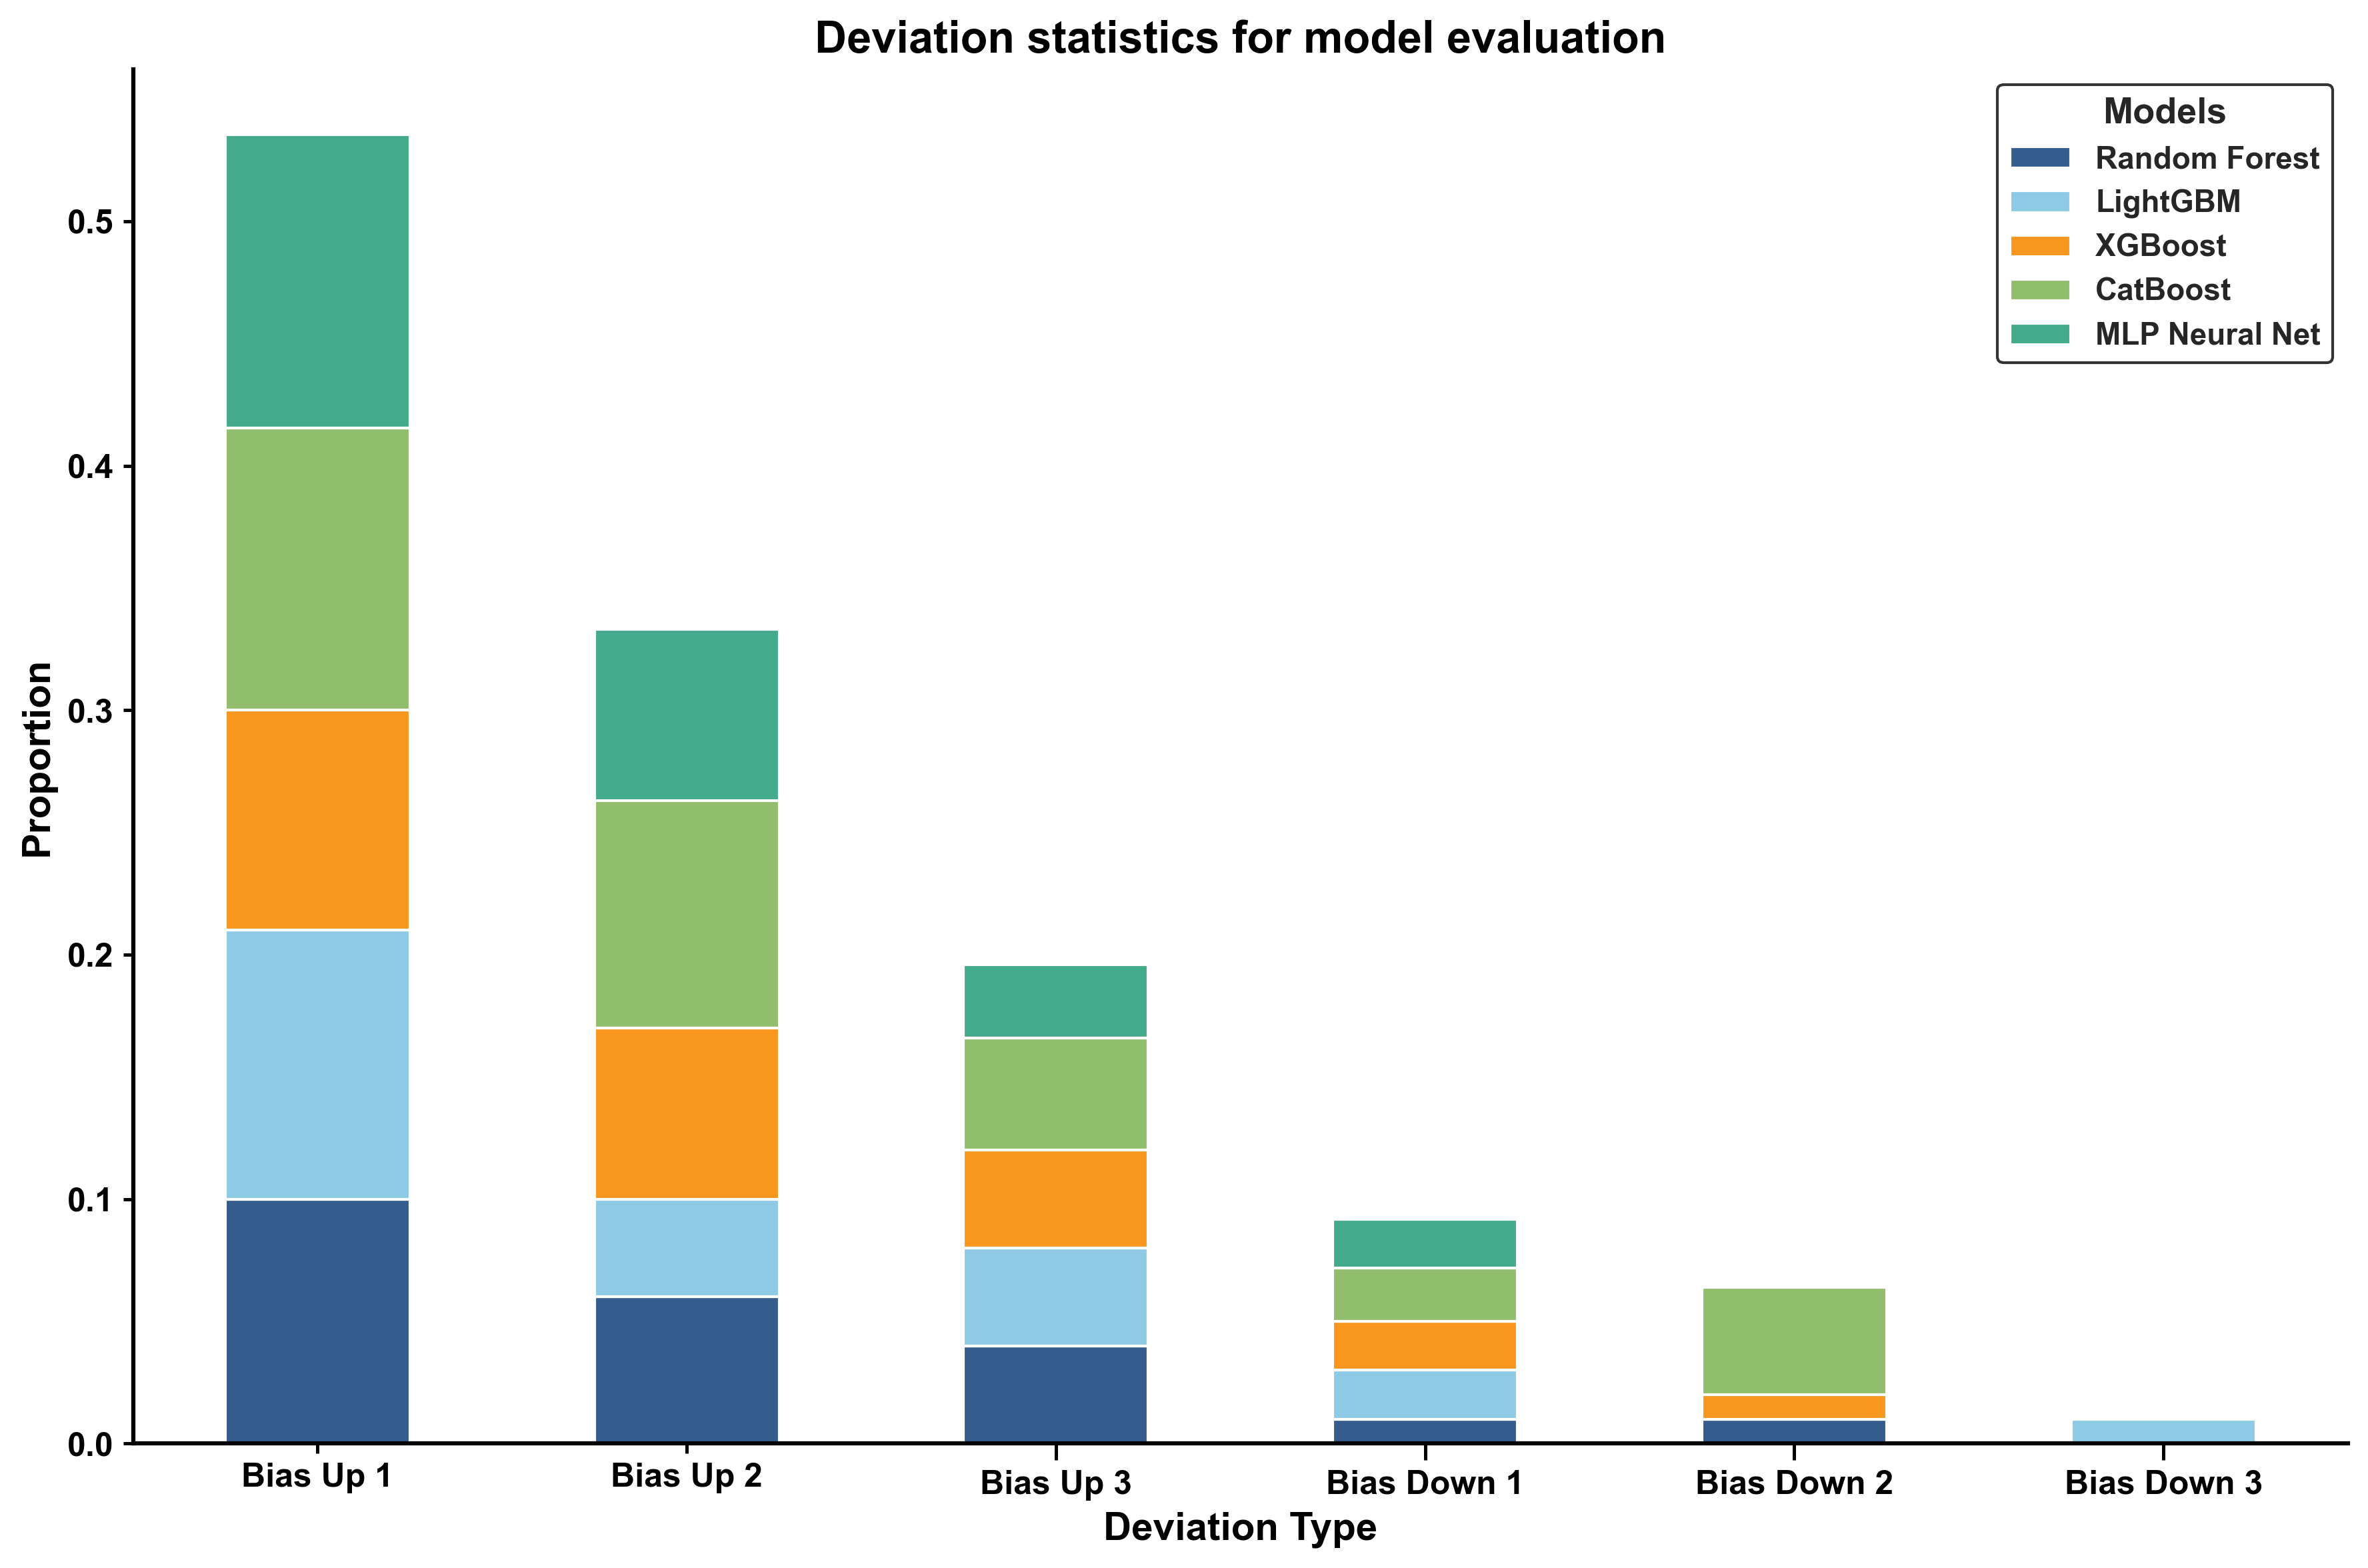

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings

# —— Global styles —— #
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.titlesize'] = 17
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'

warnings.filterwarnings("ignore")

# —— Output folder —— #
output_line_dir = 'output_line'
os.makedirs(output_line_dir, exist_ok=True)

# —— Load & preprocess —— #
data = pd.read_csv('训练4.0_filled.csv', encoding='gbk')

features = [
    '持续时间(小时)', '累计降雨量', '逐1小时最大雨量', '逐2小时最大雨量',
    '逐3小时最大雨量', '逐4小时最大雨量', '逐5小时最大雨量', '逐6小时最大雨量',
    '人均GDP', '人均可支配收入', 'tree_cover_mean',
    '人均床位数（个/万人）', '人口密度（人/平方公里）',
    '人均播种面积（千公顷/万人）', '人均房屋建筑施工面积（万平方米/人）',
    'Impervious_Surface_mean','built_density_mean',
    'slope_mean','river_density_mean','TPI_mean'
]

X = data[features].fillna(0)
y_raw = data['CPI订正的直接经济损失（万元）']

# —— Labeling into four classes —— #
bins = [0, 8000, 15000, 35000, float('inf')]
labels = ['Minor', 'Medium', 'Major', 'Catastrophic']
y_cat = pd.cut(y_raw, bins=bins, labels=labels)
le = LabelEncoder()
y_encoded = le.fit_transform(y_cat)

# —— Hold out a fixed evaluation subset  —— #
X_remain, X_eval, y_remain, y_eval = train_test_split(X, y_encoded, test_size=100, random_state=301)

# —— Model definitions—— #
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        bootstrap=True,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        objective='multiclass',
        num_class=4,
        learning_rate=0.1,
        n_estimators=300,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1
    ),
    'XGBoost': XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        learning_rate=0.1,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42
    ),
    'CatBoost': CatBoostClassifier(
        loss_function='MultiClass',
        iterations=500,
        depth=6,
        learning_rate=0.1,
        l2_leaf_reg=3.0,
        random_state=42,
        verbose=0
    ),
    'MLP Neural Net': MLPClassifier(
        hidden_layer_sizes=(100,), 
        max_iter=1000, 
        alpha=0.001,
        random_state=42
    )
}

# —— Deviation stats helper —— #
def calculate_deviation_statistics(y_true, y_pred, model_name):
    correct = np.sum(y_pred == y_true)
    bias_up_1 = np.sum(y_pred == (y_true + 1))
    bias_up_2 = np.sum(y_pred == (y_true + 2))
    bias_up_3 = np.sum(y_pred == (y_true + 3))
    bias_down_1 = np.sum(y_pred == (y_true - 1))
    bias_down_2 = np.sum(y_pred == (y_true - 2))
    bias_down_3 = np.sum(y_pred == (y_true - 3))
    deviation_stats = {
        "Model": model_name,
        "Correct": correct,
        "Bias Up 1": bias_up_1,
        "Bias Up 2": bias_up_2,
        "Bias Up 3": bias_up_3,
        "Bias Down 1": bias_down_1,
        "Bias Down 2": bias_down_2,
        "Bias Down 3": bias_down_3
    }
    return deviation_stats

# —— Plot deviation stacked bars —— #
def plot_deviation_statistics(model_deviations):
    df_deviations = pd.DataFrame(model_deviations)
    deviation_types = ['Bias Up 1', 'Bias Up 2', 'Bias Up 3', 'Bias Down 1', 'Bias Down 2', 'Bias Down 3']
    total = df_deviations[deviation_types + ['Correct']].sum(axis=1)
    for col in deviation_types:
        df_deviations[col] = df_deviations[col] / total

    custom_colors = ['#345c8c', '#8ecae6', '#f8961e', '#90be6d', '#43aa8b']
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    sns.set(style="white")

    df_deviations.set_index('Model')[deviation_types].T.plot(
        kind='bar',
        stacked=True,
        color=custom_colors,
        ax=ax
    )

    ax.set_title('Deviation statistics for model evaluation', fontsize=16, fontweight='bold')
    ax.set_xlabel('Deviation Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Proportion', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.2)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(
        title="Models",
        loc='upper right',
        fontsize=11,
        title_fontsize=13,
        frameon=True,
        edgecolor='black'
    )

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(output_line_dir, 'eval_model_deviation_statistics_percent.svg'), format='svg', bbox_inches='tight')
    plt.show()

# =========================================================
# =============== Monte Carlo Cross-Validation ============
# 5× random splits inside X_remain (70/30), train each model,
# 1) record per-run metrics on the internal test set (for reference)
# 2) average predict_proba on the fixed X_eval, then get final y_pred for deviation stats
# =========================================================
seeds = [101, 201, 301, 401, 501]

# keep per-model per-run metrics
records = []

# collect per-model probabilities on X_eval for averaging
eval_proba_collector = {name: [] for name in models.keys()}

for s in seeds:
    # split within X_remain to keep X_eval untouched
    X_tr, X_te, y_tr, y_te = train_test_split(X_remain, y_remain, test_size=0.3, random_state=s)

    # scale per split 
    scaler = MinMaxScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    X_eval_s = scaler.transform(X_eval)

    for name, base_model in models.items():
    
        if name == 'Random Forest':
            model_i = RandomForestClassifier(
                n_estimators=200, max_depth=None, bootstrap=True,
                class_weight='balanced', random_state=42, n_jobs=-1
            )
        elif name == 'LightGBM':
            model_i = LGBMClassifier(
                objective='multiclass', num_class=4, learning_rate=0.1,
                n_estimators=300, num_leaves=31, subsample=0.8,
                colsample_bytree=0.8, reg_lambda=1.0,
                random_state=42, verbose=-1
            )
        elif name == 'XGBoost':
            model_i = XGBClassifier(
                objective='multi:softprob', num_class=4,
                learning_rate=0.1, n_estimators=300, max_depth=6,
                subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                eval_metric='mlogloss', tree_method='hist',
                random_state=42
            )
        elif name == 'CatBoost':
            model_i = CatBoostClassifier(
                loss_function='MultiClass', iterations=500,
                depth=6, learning_rate=0.1, l2_leaf_reg=3.0,
                random_state=42, verbose=0
            )
        else:
            model_i = MLPClassifier(
                hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001,
                random_state=42
            )

        # train
        model_i.fit(X_tr_s, y_tr)

        # per-run metrics on internal test set
        y_pred_te = model_i.predict(X_te_s)

    
        y_te_arr = np.asarray(y_te).ravel()
        y_pred_te_arr = np.asarray(y_pred_te).ravel()
        correct = (y_pred_te_arr == y_te_arr).astype(int)

        # predict_proba on internal test for ROC/AUC
        proba_te = model_i.predict_proba(X_te_s)
        prob_max_te = np.max(proba_te, axis=1)
    
        try:
            fpr, tpr, _ = roc_curve(correct, prob_max_te, pos_label=1)
            roc_auc = auc(fpr, tpr)
        except ValueError:
            # occurs when correct is all 0 or all 1
            roc_auc = np.nan

        acc = accuracy_score(y_te_arr, y_pred_te_arr)
        f1 = f1_score(y_te_arr, y_pred_te_arr, average='weighted')
        kappa = cohen_kappa_score(y_te_arr, y_pred_te_arr)

        records.append({
            'Seed': s,
            'Model': name,
            'Accuracy': acc,
            'F1 Score': f1,
            'Kappa': kappa,
            'ROC AUC': roc_auc
        })

        # collect probabilities on the fixed X_eval for averaging
        proba_eval = model_i.predict_proba(X_eval_s)
        eval_proba_collector[name].append(proba_eval)

# aggregate metrics
per_run_df = pd.DataFrame(records)
avg_df = (
    per_run_df
    .groupby('Model')[['Accuracy', 'F1 Score', 'Kappa', 'ROC AUC']]
    .mean()
    .reset_index()
)


# —— Deviation stats from averaged probabilities on X_eval —— #
model_deviations = []
for name in models.keys():
    avg_proba_eval = np.mean(eval_proba_collector[name], axis=0)
    y_pred_eval = np.argmax(avg_proba_eval, axis=1)
    deviation = calculate_deviation_statistics(y_eval, y_pred_eval, name)
    model_deviations.append(deviation)

# —— Plot —— #
plot_deviation_statistics(model_deviations)


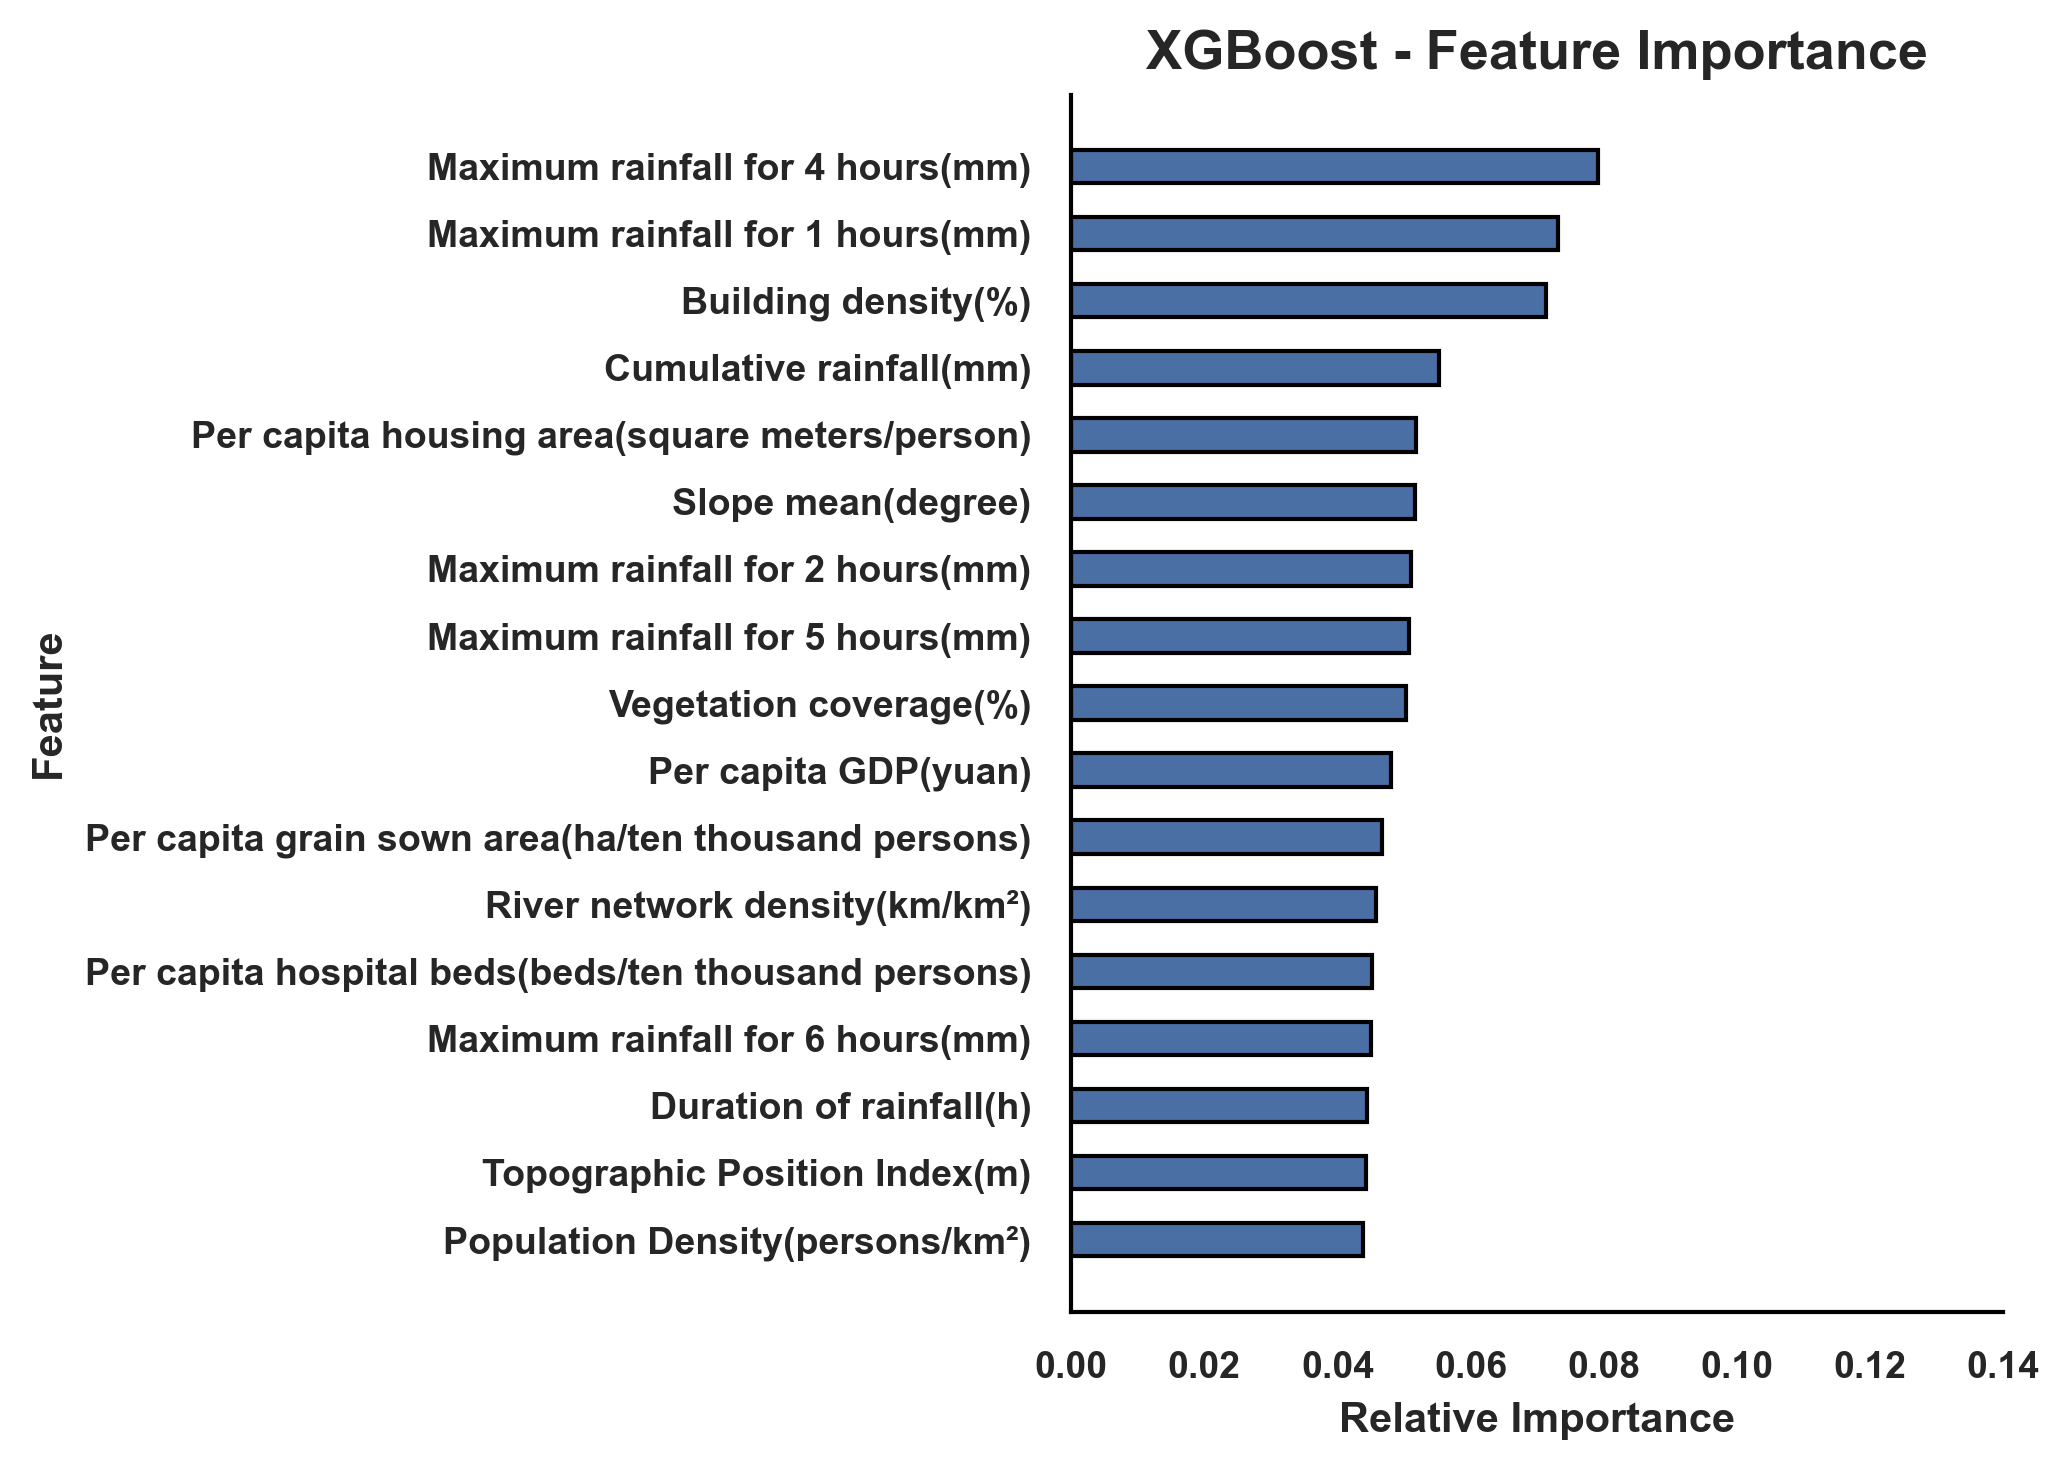


XGBoost - Feature Importances (Relative):
                                            Feature Importance
                   Maximum rainfall for 4 hours(mm)       7.9%
                   Maximum rainfall for 1 hours(mm)       7.3%
                                Building density(%)       7.1%
                            Cumulative rainfall(mm)       5.5%
      Per capita housing area(square meters/person)       5.2%
                                 Slope mean(degree)       5.2%
                   Maximum rainfall for 2 hours(mm)       5.1%
                   Maximum rainfall for 5 hours(mm)       5.1%
                             Vegetation coverage(%)       5.0%
                               Per capita GDP(yuan)       4.8%
Per capita grain sown area(ha/ten thousand persons)       4.7%
                      River network density(km/km²)       4.6%
Per capita hospital beds(beds/ten thousand persons)       4.5%
                   Maximum rainfall for 6 hours(mm)       4.5%
            

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
import warnings
from matplotlib import rcParams

warnings.filterwarnings("ignore")

# —— Figure style settings  —— #
rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10,
    'axes.labelweight': 'bold',
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})

# —— Feature mapping —— #
feature_mapping = {
    '持续时间(小时)': 'Duration of rainfall(h)',
    '累计降雨量': 'Cumulative rainfall(mm)',
    '逐1小时最大雨量': 'Maximum rainfall for 1 hours(mm)',
    '逐2小时最大雨量': 'Maximum rainfall for 2 hours(mm)',
    '逐3小时最大雨量': 'Maximum rainfall for 3 hours(mm)',
    '逐4小时最大雨量': 'Maximum rainfall for 4 hours(mm)',
    '逐5小时最大雨量': 'Maximum rainfall for 5 hours(mm)',
    '逐6小时最大雨量': 'Maximum rainfall for 6 hours(mm)',  
    '人均GDP': 'Per capita GDP(yuan)',
    '人均可支配收入': 'Per capita disposable income(yuan)',
    'tree_cover_mean': 'Vegetation coverage(%)',
    '人均床位数（个/万人）': 'Per capita hospital beds(beds/ten thousand persons)', 
    '人口密度（人/平方公里）': 'Population Density(persons/km²)',
    '人均播种面积（千公顷/万人）': 'Per capita grain sown area(ha/ten thousand persons)',
    '人均房屋建筑施工面积（万平方米/人）': 'Per capita housing area(square meters/person)', 
    'Impervious_Surface_mean': 'Impervious surface(%)',
    'built_density_mean': 'Building density(%)',
    'slope_mean': 'Slope mean(degree)',
    'river_density_mean': 'River network density(km/km²)',
    'TPI_mean': 'Topographic Position Index(m)'
}

# —— Data loading & preprocessing —— #
data = pd.read_csv('训练4.0_filled.csv', encoding='gbk')
features = list(feature_mapping.values())
X = data[feature_mapping.keys()].fillna(0)
X.columns = features
y_raw = data['CPI订正的直接经济损失（万元）']

# —— Label encoding (4 classes) —— #
bins = [0, 8000, 15000, 35000, float('inf')]
labels = ['Minor Disaster', 'Medium Disaster', 'Major Disaster', 'Catastrophic Disaster']
y = pd.cut(y_raw, bins=bins, labels=labels, right=False)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# =========================================================
# ========== Monte Carlo Cross-Validation for XGBoost ============
# Perform 5 independent 70/30 random splits, average feature importances
# =========================================================
seeds = [101, 201, 301, 401, 501]
importances_runs = []

for s in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.3, random_state=s
    )
    scaler = MinMaxScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    model = XGBClassifier(
        objective='multi:softprob', num_class=4,
        learning_rate=0.1, n_estimators=300, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        eval_metric='mlogloss', tree_method='hist',
        random_state=42
    )
    model.fit(X_train_s, y_train)

    if hasattr(model, 'feature_importances_'):
        imps = model.feature_importances_
    else:
        imps = np.zeros(len(features))

    imps = imps / (np.sum(imps) + 1e-12)
    importances_runs.append(imps)

avg_importances = np.mean(np.vstack(importances_runs), axis=0)

# —— Model dictionary —— #
models_dict = {
    'XGBoost': avg_importances
}

# —— Output directory —— #
output_dir = "feature_importance_barplots"
os.makedirs(output_dir, exist_ok=True)

# —— Visualization & saving  —— #
for name, importances in models_dict.items():
    total_importance = np.sum(importances)
    relative_importances = importances / total_importance if total_importance > 0 else np.zeros_like(importances)

    fi_df = pd.DataFrame({
        'Feature': features,
        'Importance': relative_importances
    }).sort_values(by='Importance', ascending=False)

    fi_df_top = fi_df.head(17).sort_values(by='Importance', ascending=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
    ax.barh(fi_df_top['Feature'], fi_df_top['Importance'], color='#4A6FA5', edgecolor='black', height=0.5)
    ax.set_title(f'{name} - Feature Importance', fontsize=13, weight='bold')
    ax.set_xlabel('Relative Importance', fontsize=10, weight='bold')
    ax.set_ylabel('Feature', fontsize=10, weight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0, 0.14)
    ax.grid(False)
    fig.tight_layout()

    # Save figure
    save_path = os.path.join(output_dir, f'{name}feature_importance.svg')
    plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()

    # Console output for Top17
    print(f"\n{name} - Feature Importances (Relative):")
    top17_df = fi_df.head(17).copy()
    top17_df['Importance'] = top17_df['Importance'].apply(lambda x: f'{x:.1%}')
    print(top17_df.to_string(index=False))
    print("-" * 70)


Label Encoding Mapping:
Class 0 = Catastrophic Disaster
Class 1 = Major Disaster
Class 2 = Medium Disaster
Class 3 = Minor Disaster


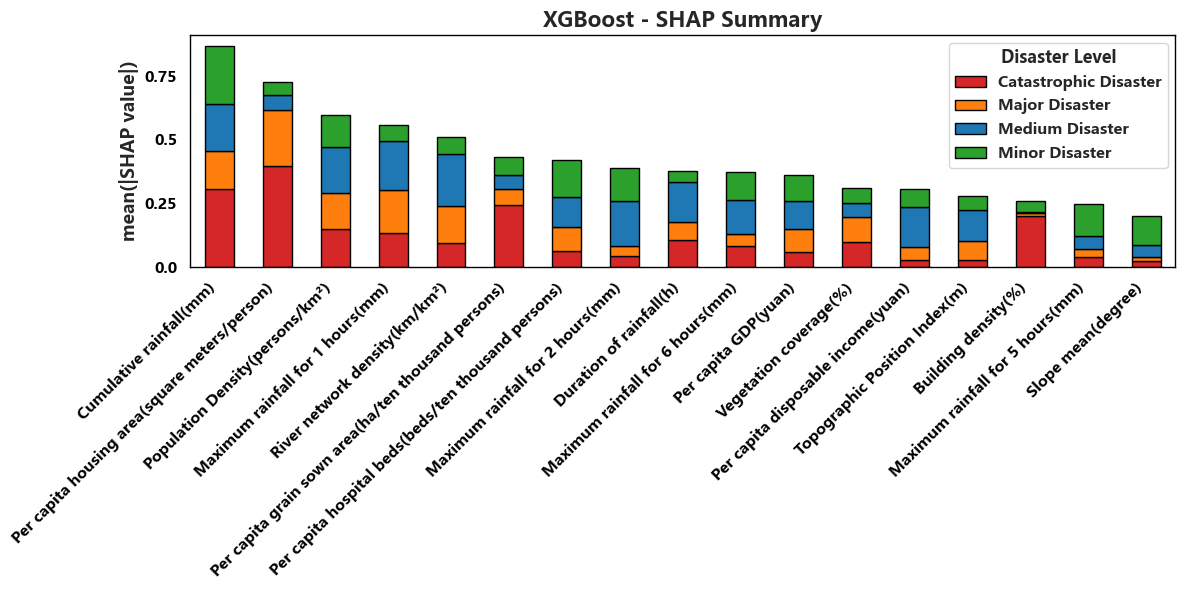

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import warnings
warnings.filterwarnings("ignore")

# ==== Step 1: Data loading & preprocessing ====
data = pd.read_csv('训练4.0_filled.csv', encoding='gbk')

feature_mapping = {
    '持续时间(小时)': 'Duration of rainfall(h)',
    '累计降雨量': 'Cumulative rainfall(mm)',
    '逐1小时最大雨量': 'Maximum rainfall for 1 hours(mm)',
    '逐2小时最大雨量': 'Maximum rainfall for 2 hours(mm)',
    '逐3小时最大雨量': 'Maximum rainfall for 3 hours(mm)',
    '逐4小时最大雨量': 'Maximum rainfall for 4 hours(mm)',
    '逐5小时最大雨量': 'Maximum rainfall for 5 hours(mm)',
    '逐6小时最大雨量': 'Maximum rainfall for 6 hours(mm)',  
    '人均GDP': 'Per capita GDP(yuan)',
    '人均可支配收入': 'Per capita disposable income(yuan)',
    'tree_cover_mean': 'Vegetation coverage(%)',
    '人均床位数（个/万人）': 'Per capita hospital beds(beds/ten thousand persons)', 
    '人口密度（人/平方公里）': 'Population Density(persons/km²)',
    '人均播种面积（千公顷/万人）': 'Per capita grain sown area(ha/ten thousand persons)',
    '人均房屋建筑施工面积（万平方米/人）': 'Per capita housing area(square meters/person)', 
    'Impervious_Surface_mean': 'Impervious surface(%)',
    'built_density_mean': 'Building density(%)',
    'slope_mean': 'Slope mean(degree)',
    'river_density_mean': 'River network density(km/km²)',
    'TPI_mean': 'Topographic Position Index(m)'
}

features = list(feature_mapping.values())
X = data[feature_mapping.keys()].fillna(0)
X.columns = features
y = data['CPI订正的直接经济损失（万元）']

# Label binning (4 classes)
bins = [0, 8000, 15000, 35000, float('inf')]
labels = ['Minor Disaster', 'Medium Disaster', 'Major Disaster', 'Catastrophic Disaster']
y = pd.cut(y, bins=bins, labels=labels, right=False)
y = y[y.isin(labels)]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ==== Step 2: Monte Carlo Cross-Validation ====
# 5 independent 70/30 splits; SHAP computed per split and then averaged
seeds = [101, 201, 301, 401, 501]
mean_abs_shap_runs = []  # collects (n_classes, n_features) per split

for s in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.3, random_state=s
    )
    scaler = MinMaxScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    xgb_model = XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        learning_rate=0.1,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42
    )
    xgb_model.fit(X_train_s, y_train)

    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test_s)  # list of (n_samples, n_features) per class

    shap_array = np.stack(shap_values, axis=1)       # (n_samples, n_classes, n_features)
    mean_abs_shap_split = np.abs(shap_array).mean(axis=0)
    mean_abs_shap_runs.append(mean_abs_shap_split)

# Average across splits -> (n_classes, n_features)
mean_abs_shap = np.mean(np.stack(mean_abs_shap_runs, axis=0), axis=0)

# ==== Step 3: Build DataFrame for plotting ====
ordered_class_names = ['Catastrophic Disaster', 'Major Disaster', 'Medium Disaster', 'Minor Disaster']

mean_abs_df = pd.DataFrame(
    mean_abs_shap.T,  # (n_features, n_classes)
    columns=list(le.classes_),
    index=features
)
mean_abs_df = mean_abs_df[ordered_class_names]

# Sort by total contribution and select top-17 features
mean_abs_df = mean_abs_df.loc[mean_abs_df.sum(axis=1).sort_values(ascending=False).index]
mean_abs_df_top17 = mean_abs_df.head(17)

# ==== Step 4: Visualization ====
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['xtick.labelsize'] = 11
matplotlib.rcParams['ytick.labelsize'] = 11
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['legend.fontsize'] = 11

color_map = {
    'Catastrophic Disaster': '#d62728',  # red
    'Major Disaster': '#ff7f0e',         # orange
    'Medium Disaster': '#1f77b4',        # blue
    'Minor Disaster': '#2ca02c'          # green
}
colors = [color_map[c] for c in ordered_class_names]

ax = mean_abs_df_top17.plot.bar(
    stacked=True,
    figsize=(12, 6),
    color=colors,
    edgecolor='black'
)

ax.set_ylabel("mean(|SHAP value|)", fontsize=13, fontweight='bold')
ax.set_title("XGBoost - SHAP Summary", fontsize=15, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11, fontweight='bold')

# --- Fix the y-axis labels to avoid long floats ---
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))
y_max_stack = float(np.max(mean_abs_df_top17.sum(axis=1)))
y_max_rounded = np.ceil(y_max_stack * 10) / 10.0 if y_max_stack > 0 else 0.1
ax.set_ylim(0, y_max_rounded)

ax.legend(title="Disaster Level", title_fontsize=12, fontsize=11)

plt.tight_layout()
plt.savefig("xgboost_shap_top17_fixed_order.svg", format="svg", dpi=300, bbox_inches='tight')
plt.show()
